<a id='ксодержанию'></a>
## Содержание
* [Импорт библиотек](#Импортбиблиотек)
* [Некоторые методы](#Некоторыеметоды)
* [Загрузка данных](#Загрузкаданных)
* [specialization](#specialization)
* [prof_area](#prof_area)

<a id='Импортбиблиотек'></a> 
# Импорт библиотек
[к содержанию](#ксодержанию)

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from tabulate import tabulate
import joblib
import numpy as np
from sklearn.linear_model import LogisticRegression
import pandas as pd

In [3]:
import joblib
import matplotlib
import seaborn as sns
from matplotlib import pyplot
matplotlib.rcParams['figure.figsize'] = (18, 4)

<a id='Некоторыеметоды'></a> 
# Некоторые методы
[к содержанию](#ксодержанию)

In [5]:
def salary_process(df: pd.DataFrame):
  # Переводим з/п в рубли по курсу на 09.12.2021
  currency = {'RUR': 1, 'BYR': 29.04, 'KZT': 0.17, 'UZS': 0.0068, 'UAH': 2.72, 'USD': 73.66, 'KGS': 0.87, 'EUR': 83.32, 'AZN': 43.33, 'GEL': 23.73}
  # Переводим з/п в нерублёвых валютах в рубли
  for curr in df['salary_currency'].unique():
      df['salary_from'][df['salary_currency'] == curr] = df['salary_from'][df['salary_currency'] == curr].apply(lambda x: x*currency[curr])
  # Нормируем на НДФЛ для каждой страны
  df.loc[(df['salary_gross'] == False) & ((df['country_name'] == 'Россия') | (df['country_name'] == 'Беларусь')), 'salary_from'] = df['salary_from'] / 0.87
  df.loc[(df['salary_gross'] == False) & ((df['country_name'] == 'Казахстан') | (df['country_name'] == 'Кыргызстан')), 'salary_from'] = df['salary_from'] / 0.9
  df.loc[(df['salary_gross'] == False) & (df['country_name'] == 'Украина'), 'salary_from'] = df['salary_from'] / 0.82
  df.loc[(df['salary_gross'] == False) & (df['country_name'] == 'Грузия'), 'salary_from'] = df['salary_from'] / 0.8

In [13]:
def fill_prof_area(prof_areas, row:  list):
  """
  Создаём метод, который заполняет словарь prof_area сферами и частотой их встречания в вакансиях
  Аргумент:
  row - строка в датафрейме
  """
  for el in row:
    if el in prof_areas:
      prof_areas[el] += 1
    else:
      prof_areas[el] = 1

def decrease_specializations(x: str):
  """
  Создаём метод, которые вместо наименее популярных специализаций пишет "Другое"
  Аргумент:
  х - специализация
  Возвращает:
  х - специализация
  """
  try:
    if specializations[x]/len(df) < 0.01:
      return 'Другое'
    else:
      return x
  except:
    return x

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
def report(df: pd.DataFrame, y_test: pd.DataFrame, y_pred: np.array, col: str):
  salary_groupped_prof_area = df[[col, 'salary_from']].groupby([col]).mean()
  salary_groupped_prof_area_std = df[[col, 'salary_from']].groupby([col]).std()
  salary_pred = salary_groupped_prof_area.loc[y_pred]
  salary_test = df.loc[y_test.index, 'salary_from']
  salary = pd.DataFrame()
  salary['y_pred'] = y_pred
  salary['test'] =  list(salary_test)
  salary['pred'] = list(salary_pred['salary_from'])
  salary['true'] = list(df.loc[y_test.index, col])
  salary = salary.dropna()
  regression_report = []
  for area in salary['true'].unique():
    regression_report.append([round(mean_absolute_error(salary['pred'][salary['true'] == area], salary['test'][salary['true'] == area]), 1),
    round(float(salary_groupped_prof_area.loc[area]), 1), round(float(salary_groupped_prof_area_std.loc[area]), 1)])
  return regression_report, salary

In [51]:
def specialization(df: pd.DataFrame, y_pred: str):
  y_pred = joblib.load(y_pred)
  df = df[~df['specialization'].isnull()]
  specializations = dict()
  df['specializations_name'].apply(lambda x: fill_prof_area(specializations, eval(x)));
  df['specialization'] = df['specialization'].apply(decrease_specializations)
  y_train, y_test = train_test_split(df['specialization'], test_size=0.2, random_state=42)
  report_class = pd.DataFrame(metrics.classification_report(y_test, y_pred, output_dict=True)).T
  regression_report, salary = report(df=df, y_test=y_test, y_pred=y_pred, col='specialization')
  regression_report = pd.DataFrame(regression_report)
  regression_report.columns = ['MAE', 'salary_from_mean', 'salary_from_std']
  regression_report.index = salary['true'].unique()
  return report_class, regression_report

In [62]:
def prof_area(df: pd.DataFrame, y_pred: str):
  y_pred = joblib.load(y_pred)
  y_train, y_test = train_test_split(df['prof_area'], test_size=0.2, random_state=42)
  report_class = pd.DataFrame(metrics.classification_report(y_test, y_pred, output_dict=True)).T
  regression_report, salary = report(df=df, y_test=y_test, y_pred=y_pred, col='prof_area')
  regression_report = pd.DataFrame(regression_report)
  regression_report.columns = ['MAE', 'salary_from_mean', 'salary_from_std']
  regression_report.index = salary['true'].unique()
  return report_class, regression_report

In [75]:
def regression(df: pd.DataFrame, y_pred: str):
  df = df[['raw_description', 'salary_from', 'prof_area']].dropna()
  y_pred = joblib.load(y_pred)
  y_train, y_test = train_test_split(df['salary_from'], test_size=0.2, random_state=42)
  col = 'prof_area'
  salary_groupped_prof_area = df[[col, 'salary_from']].groupby([col]).mean()
  salary_groupped_prof_area_std = df[[col, 'salary_from']].groupby([col]).std()
  salary_test = df.loc[y_test.index, 'salary_from']
  salary = pd.DataFrame()
  salary['test'] =  list(salary_test)
  salary['pred'] = list(y_pred)
  salary['true'] = list(df.loc[y_test.index, col])
  regression_report = []
  for area in salary['true'].unique():
    regression_report.append([round(mean_absolute_error(salary['pred'][salary['true'] == area], salary['test'][salary['true'] == area]), 1),
    round(float(salary_groupped_prof_area.loc[area]), 1), round(float(salary_groupped_prof_area_std.loc[area]), 1)])
  regression_report = pd.DataFrame(regression_report)
  regression_report.columns = ['MAE', 'salary_from_mean', 'salary_from_std']
  regression_report.index = salary['true'].unique()
  return regression_report

<a id='Загрузкаданных'></a> 
# Загрузка данных
[к содержанию](#ксодержанию)

In [52]:
!gdown --id 1A-59GMNuJWbrbCc17zvBPkOycSdCBdCA
!gdown --id 1G5OXqdq9rQo7XWqdAk2FO3uXbQiymNw0
df = pd.read_csv('vacancies_lemmatized.csv')
df2 = pd.read_csv('hhparser_vacancy.csv')
df2['raw_description'] = df2['description']
df2.loc[(df2['salary_gross'] == False), 'salary_from'] = df2['salary_from'] / 0.87
df = df[df['language'] == 'ru']
salary_process(df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# specialization
<a id='specialization'></a> 
[к содержанию](#ксодержанию)

In [ ]:
classification_report1, regression_report1  = specialization(df, 'y_pred_lem_desc_tfidf_RF_specialization.pkl')
classification_report2, regression_report2  = specialization(df, 'y_pred_raw_desc_tfidf_RF_specialization.pkl')

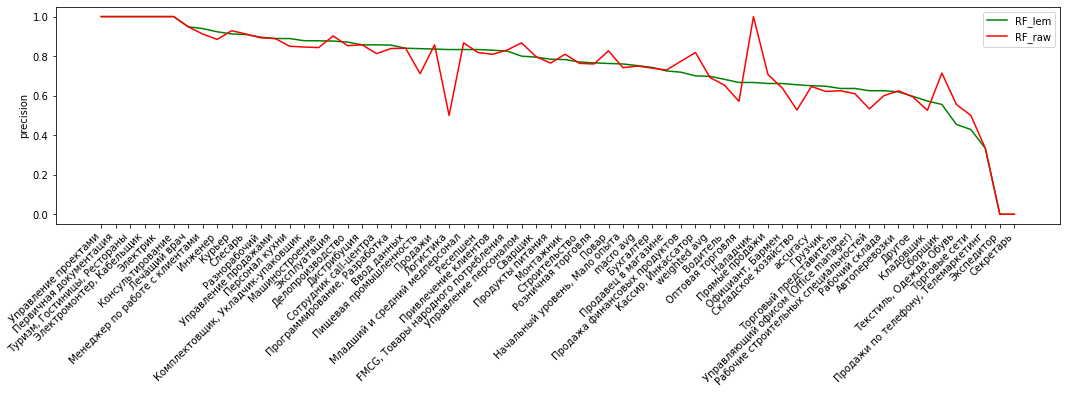

In [54]:
metric = classification_report1.sort_values(by=['precision'], ascending=False)
sns.lineplot(x=metric.index, y=metric['precision'], color='green', label='RF_lem')
sns.lineplot(x=classification_report2.index, y=classification_report2['precision'], color='red', label='RF_raw')
pyplot.xticks(rotation=45, ha="right");

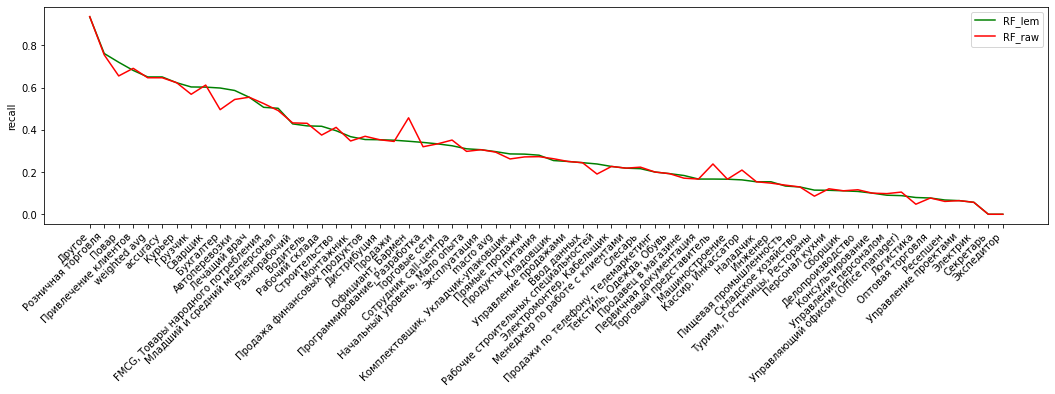

In [55]:
metric = classification_report1.sort_values(by=['recall'], ascending=False)
sns.lineplot(x=metric.index, y=metric['recall'], color='green', label='RF_lem')
sns.lineplot(x=classification_report2.index, y=classification_report2['recall'], color='red', label='RF_raw')
pyplot.xticks(rotation=45, ha="right");

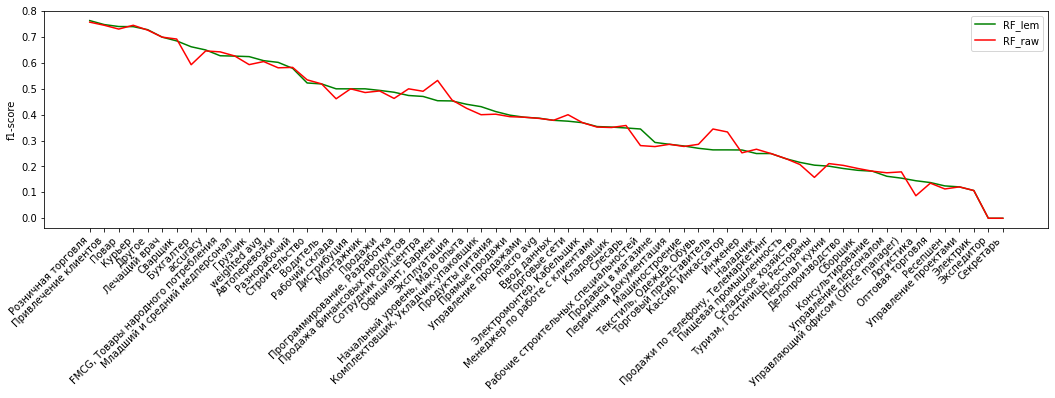

In [56]:
metric = classification_report1.sort_values(by=['f1-score'], ascending=False)
sns.lineplot(x=metric.index, y=metric['f1-score'], color='green', label='RF_lem')
sns.lineplot(x=classification_report2.index, y=classification_report2['f1-score'], color='red', label='RF_raw')
pyplot.xticks(rotation=45, ha="right");

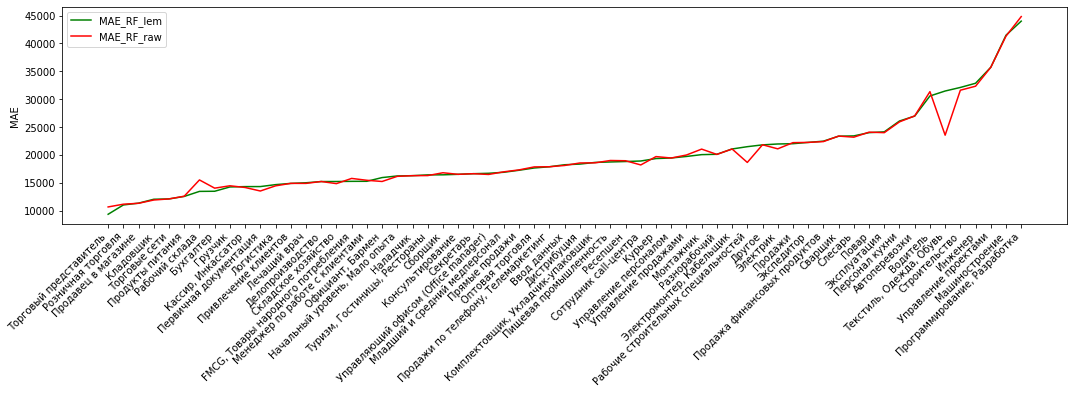

In [58]:
metric = regression_report1.sort_values(by=['MAE'])
sns.lineplot(x=metric.index, y=metric['MAE'], color='green', label='MAE_RF_lem')
sns.lineplot(x=regression_report2.index, y=regression_report2['MAE'], color='red', label='MAE_RF_raw')
pyplot.xticks(rotation=45, ha="right");

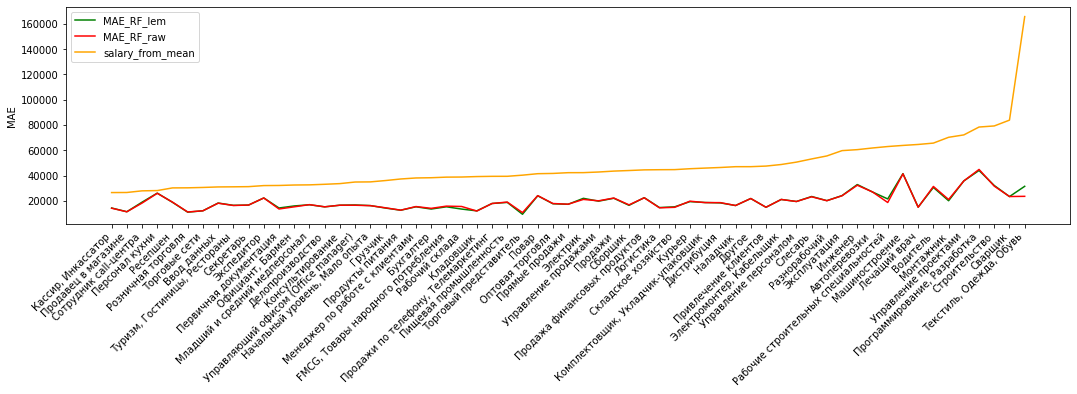

In [61]:
metric = regression_report1.sort_values(by=['salary_from_mean'])
sns.lineplot(x=metric.index, y=metric['MAE'], color='green', label='MAE_RF_lem')
sns.lineplot(x=regression_report2.index, y=regression_report2['MAE'], color='red', label='MAE_RF_raw')
pyplot.xticks(rotation=45, ha="right");
sns.lineplot(x=regression_report2.index, y=regression_report2['salary_from_mean'], color='orange', label='salary_from_mean')
# sns.lineplot(x=regression_report2.index, y=regression_report2['salary_from_std'], color='darkblue', label='salary_from_std')

# prof_area
<a id='prof_area'></a> 
[к содержанию](#ксодержанию)

In [ ]:
df = pd.read_csv('vacancies_lemmatized.csv')
df = df[df['language'] == 'ru']
salary_process(df)

In [ ]:
classification_report1, regression_report1  = prof_area(df, 'y_pred_lem_desc_tfidf_LR_prof_area_14000.pkl')
classification_report2, regression_report2  = prof_area(df, 'y_pred_lem_desc_tfidf_RF_prof_area.pkl')
classification_report3, regression_report3  = prof_area(df, 'y_pred_raw_desc_tfidf_LR_prof_area_with_len.pkl')
classification_report4, regression_report4  = prof_area(df, 'y_pred_raw_desc_tfidf_RF_prof_area.pkl')

In [76]:
df = pd.read_csv('vacancies_lemmatized.csv')
salary_process(df)
regression_report5  = regression(df[df['country_name'] == 'Россия'], 'y_pred_raw_desc_tfidf_Ridge_only_Russia.pkl')
regression_report6  = regression(df[df['language'] == 'ru'], 'y_pred_raw_desc_tfidf_Ridge.pkl')

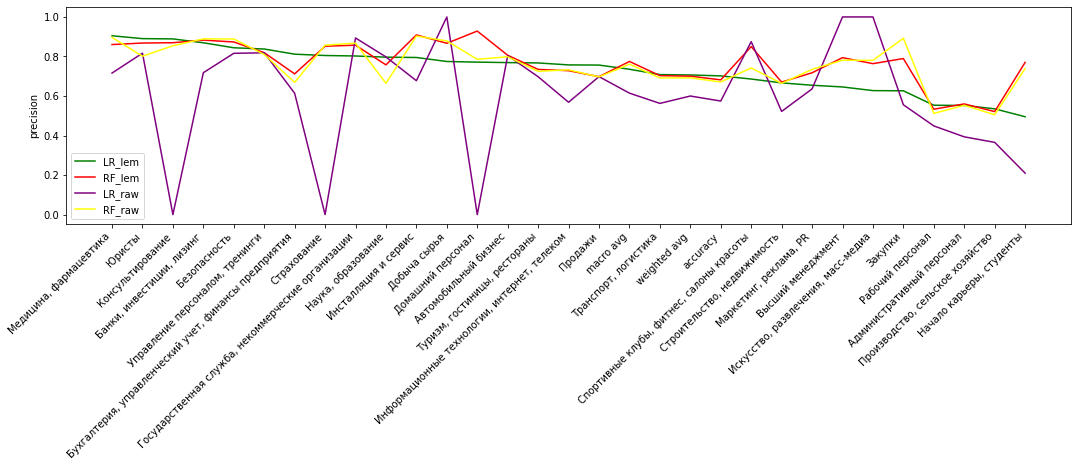

In [66]:
metric = classification_report1.sort_values(by=['precision'], ascending=False)
sns.lineplot(x=metric.index, y=metric['precision'], color='green', label='LR_lem')
sns.lineplot(x=classification_report2.index, y=classification_report2['precision'], color='red', label='RF_lem')
sns.lineplot(x=classification_report3.index, y=classification_report3['precision'], color='purple', label='LR_raw')
sns.lineplot(x=classification_report4.index, y=classification_report4['precision'], color='yellow', label='RF_raw')
pyplot.xticks(rotation=45, ha="right");

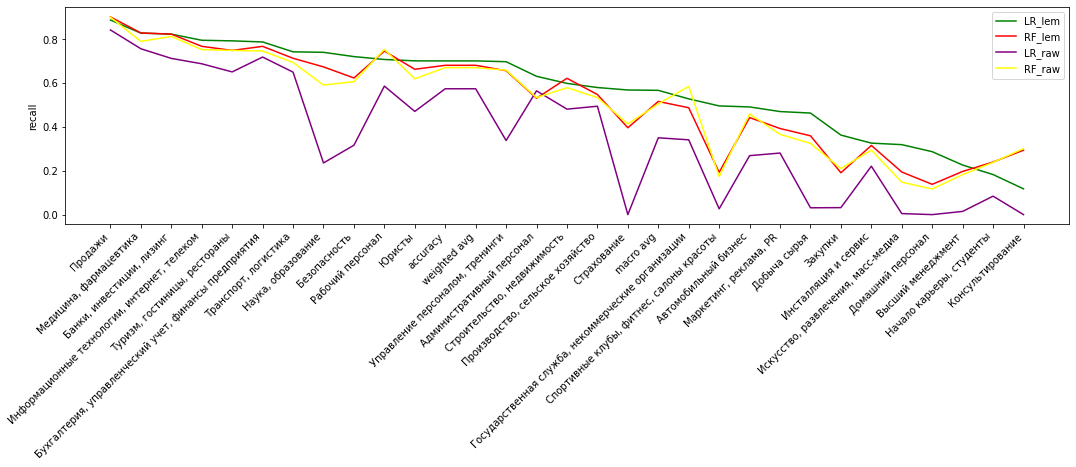

In [77]:
metric = classification_report1.sort_values(by=['recall'], ascending=False)
sns.lineplot(x=metric.index, y=metric['recall'], color='green', label='LR_lem')
sns.lineplot(x=classification_report2.index, y=classification_report2['recall'], color='red', label='RF_lem')
sns.lineplot(x=classification_report3.index, y=classification_report3['recall'], color='purple', label='LR_raw')
sns.lineplot(x=classification_report4.index, y=classification_report4['recall'], color='yellow', label='RF_raw')
pyplot.xticks(rotation=45, ha="right");

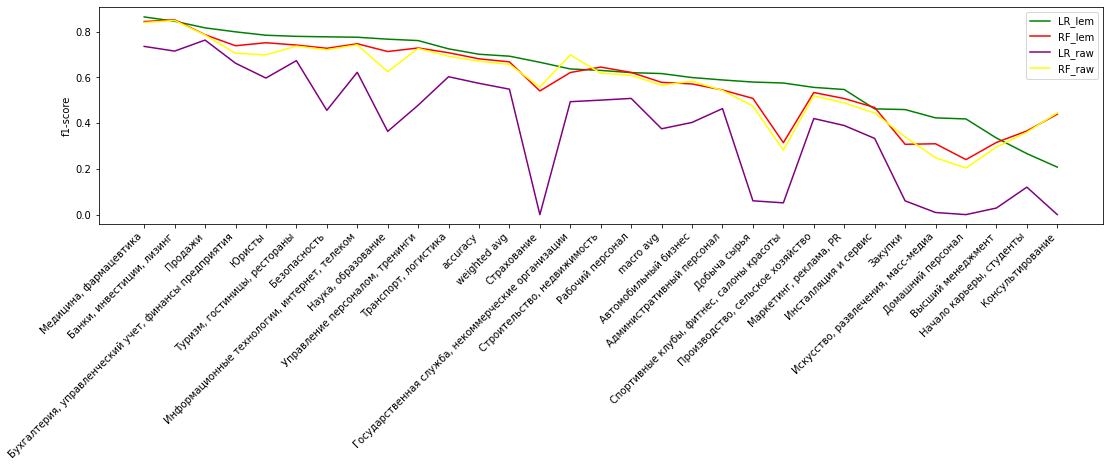

In [78]:
metric = classification_report1.sort_values(by=['f1-score'], ascending=False)
sns.lineplot(x=metric.index, y=metric['f1-score'], color='green', label='LR_lem')
sns.lineplot(x=classification_report2.index, y=classification_report2['f1-score'], color='red', label='RF_lem')
sns.lineplot(x=classification_report3.index, y=classification_report3['f1-score'], color='purple', label='LR_raw')
sns.lineplot(x=classification_report4.index, y=classification_report4['f1-score'], color='yellow', label='RF_raw')
pyplot.xticks(rotation=45, ha="right");

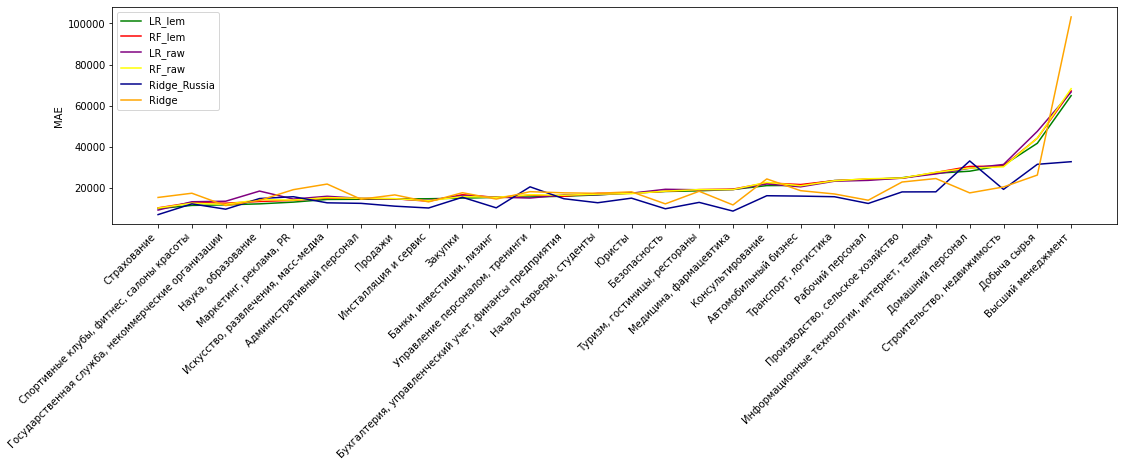

In [84]:
metric = regression_report1.sort_values(by=['MAE'])
sns.lineplot(x=metric.index, y=metric['MAE'], color='green', label='LR_lem')
sns.lineplot(x=regression_report2.index, y=regression_report2['MAE'], color='red', label='RF_lem')
sns.lineplot(x=regression_report3.index, y=regression_report3['MAE'], color='purple', label='LR_raw')
sns.lineplot(x=regression_report4.index, y=regression_report4['MAE'], color='yellow', label='RF_raw')
sns.lineplot(x=regression_report5.index, y=regression_report5['MAE'], color='darkblue', label='Ridge_Russia')
sns.lineplot(x=regression_report6.index, y=regression_report6['MAE'], color='orange', label='Ridge')
pyplot.xticks(rotation=45, ha="right");

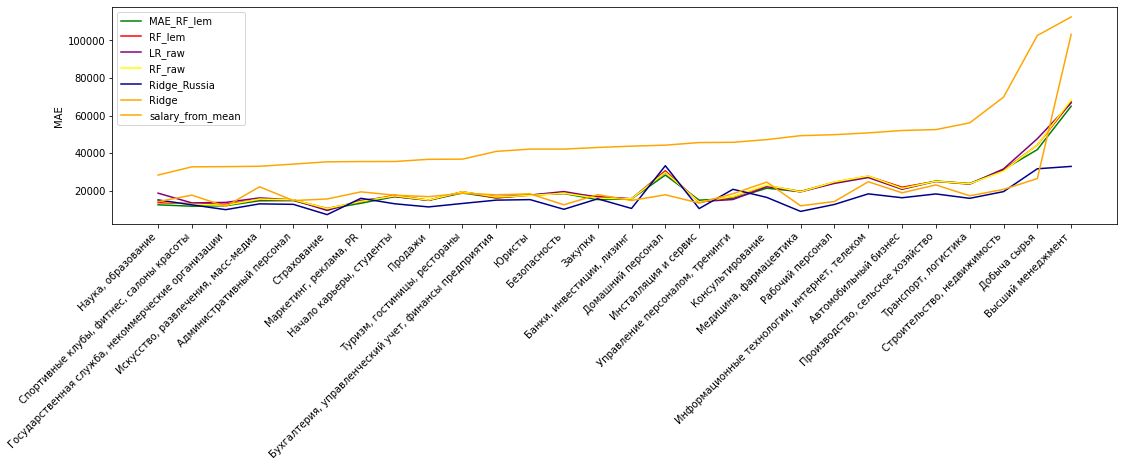

In [85]:
metric = regression_report1.sort_values(by=['salary_from_mean'])
sns.lineplot(x=metric.index, y=metric['MAE'], color='green', label='MAE_RF_lem')
sns.lineplot(x=regression_report2.index, y=regression_report2['MAE'], color='red', label='RF_lem')
sns.lineplot(x=regression_report3.index, y=regression_report3['MAE'], color='purple', label='LR_raw')
sns.lineplot(x=regression_report4.index, y=regression_report4['MAE'], color='yellow', label='RF_raw')
sns.lineplot(x=regression_report5.index, y=regression_report5['MAE'], color='darkblue', label='Ridge_Russia')
sns.lineplot(x=regression_report6.index, y=regression_report6['MAE'], color='orange', label='Ridge')
pyplot.xticks(rotation=45, ha="right");
sns.lineplot(x=regression_report2.index, y=regression_report2['salary_from_mean'], color='orange', label='salary_from_mean')
# sns.lineplot(x=regression_report2.index, y=regression_report2['salary_from_std'], color='darkblue', label='salary_from_std')